In [ ]:
!pip install tensorboardX 
!pip install torchsummary

In [ ]:
import torch
import torch.optim as optim

from tensorboardX import SummaryWriter
import numpy as np
import json
import os
from tqdm import tqdm, trange
import h5py
from prettytable import PrettyTable
from torchsummary import summary
import torch.nn as nn
from collections import OrderedDict 

import pprint
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

H5PY_DEFAULT_READONLY=1


In [ ]:
class FCSN(nn.Module):
    def __init__(self, n_class=2):
        super(FCSN, self).__init__()

        self.conv1 = nn.Sequential(OrderedDict([
            ('convRED_1', nn.Conv1d(1024, 512, 3, padding=1)),
            ('convRED_2', nn.Conv1d(512, 512, 3, padding=1)),
            ('convRED_3', nn.Conv1d(512,256 , 3, padding=1)),
            ('conv1_1', nn.Conv1d(256, 256, 3, padding=1)),
            ('bn1_1', nn.BatchNorm1d(256)),
            ('relu1_1', nn.ReLU(inplace=True)),
            ('conv1_2', nn.Conv1d(256, 256, 3, padding=1)),
            ('bn1_2', nn.BatchNorm1d(256)),
            ('relu1_2', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool1d(2, stride=2, ceil_mode=True))
            ])) # 1/2

        self.conv2 = nn.Sequential(OrderedDict([
            ('conv2_1', nn.Conv1d(256, 256, 3, padding=1)),
            ('bn2_1', nn.BatchNorm1d(256)),
            ('relu2_1', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool1d(2, stride=2, ceil_mode=True))
            ])) # 1/4

        self.conv3 = nn.Sequential(OrderedDict([
            ('conv3_1', nn.Conv1d(256, 256, 3, padding=1)),
            ('bn3_1', nn.BatchNorm1d(256)),
            ('relu3_1', nn.ReLU(inplace=True)),
            ('conv3_2', nn.Conv1d(256, 256, 3, padding=1)),
            ('bn3_2', nn.BatchNorm1d(256)),
            ('relu3_2', nn.ReLU(inplace=True)),
            ('pool3', nn.MaxPool1d(2, stride=2, ceil_mode=True))
            ])) # 1/8

        self.conv4 = nn.Sequential(OrderedDict([
            ('conv4_1', nn.Conv1d(256, 512, 3, padding=1)),
            ('bn4_1', nn.BatchNorm1d(512)),
            ('relu4_1', nn.ReLU(inplace=True)),
            ('conv4_2', nn.Conv1d(512, 512, 3, padding=1)),
            ('bn4_2', nn.BatchNorm1d(512)),
            ('relu4_2', nn.ReLU(inplace=True)),
            ('pool4', nn.MaxPool1d(2, stride=2, ceil_mode=True))
            ])) # 1/16

        self.conv5 = nn.Sequential(OrderedDict([
            ('conv5_1', nn.Conv1d(512, 512, 3, padding=1)),
            ('bn5_1', nn.BatchNorm1d(512)),
            ('relu5_1', nn.ReLU(inplace=True)),
            ('conv5_2', nn.Conv1d(512, 512, 3, padding=1)),
            ('bn5_2', nn.BatchNorm1d(512)),
            ('relu5_2', nn.ReLU(inplace=True)),
            ('pool5', nn.MaxPool1d(2, stride=2, ceil_mode=True))
            ])) # 1/32

        self.conv6 = nn.Sequential(OrderedDict([
            ('fc6', nn.Conv1d(512, 1024, 1)),
            ('bn6', nn.BatchNorm1d(1024)),
            ('relu6', nn.ReLU(inplace=True)),
            ('drop6', nn.Dropout())
            ]))
   
        self.conv7 = nn.Sequential(OrderedDict([
            ('fc7', nn.Conv1d(1024, 1024, 1)),
            ('bn7', nn.BatchNorm1d(1024)),
            ('relu7', nn.ReLU(inplace=True)),
            ('drop7', nn.Dropout())
            ]))

        self.conv8 = nn.Sequential(OrderedDict([
            ('fc8', nn.Conv1d(1024, n_class, 1)),
            ('bn8', nn.BatchNorm1d(n_class)),
            ('relu8', nn.ReLU(inplace=True)),
            ]))

        self.conv_pool4 = nn.Conv1d(512, n_class, 1)
        self.bn_pool4 = nn.BatchNorm1d(n_class)

        self.conv_pool3=nn.Conv1d(256,n_class,1)
        self.bn_pool3=nn.BatchNorm1d(n_class)

        self.deconv1 = nn.ConvTranspose1d(n_class, n_class, 4, padding=1, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose1d(n_class, n_class, 4, padding=1, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose1d(n_class, n_class, 8, stride=8, bias=False)

    def forward(self, x):

        h = x
        h = self.conv1(h)
        h = self.conv2(h)
        h = self.conv3(h)
        pool3 = h
        h = self.conv4(h)
        pool4 = h

        h = self.conv5(h)
        h = self.conv6(h)
        h = self.conv7(h)
        h = self.conv8(h)

        h = self.deconv1(h)
        upscore2 = h

        h = self.conv_pool4(pool4)
        h = self.bn_pool4(h)
        score_pool4 = h

        h = upscore2 + score_pool4

        h = self.deconv2(h)

        upscore3 = h
        h = self.conv_pool3(pool3)
        h = self.bn_pool3(h)
        score_pool3 = h

        h = upscore3 + score_pool3
        
        h= self.deconv3(h)
        
        return h


#import torch
#net = FCSN()
#data = torch.randn((1, 1024, 320))
#print(net(data).shape)

In [ ]:
def knapsack(v, w, max_weight):
    rows = len(v) + 1
    cols = max_weight + 1

    # adding dummy values as later on we consider these values as indexed from 1 for convinence
    
    v = np.r_[[0], v]
    w = np.r_[[0], w]

    # row : values , #col : weights
    dp_array = [[0 for i in range(cols)] for j in range(rows)]

    # 0th row and 0th column have value 0

    # values
    for i in range(1, rows):
        # weights
        for j in range(1, cols):
            # if this weight exceeds max_weight at that point
            if j - w[i] < 0:
                dp_array[i][j] = dp_array[i - 1][j]

            # max of -> last ele taken | this ele taken + max of previous values possible
            else:
                dp_array[i][j] = max(dp_array[i - 1][j], v[i] + dp_array[i - 1][j - w[i]])

    # return dp_array[rows][cols]  : will have the max value possible for given wieghts

    chosen = []
    i = rows - 1
    j = cols - 1

    # Get the items to be picked
    while i > 0 and j > 0:

        # ith element is added
        if dp_array[i][j] != dp_array[i - 1][j]:
            # add the value
            chosen.append(i-1)
            # decrease the weight possible (j)
            j = j - w[i]
            # go to previous row
            i = i - 1

        else:
            i = i - 1

    return dp_array[rows - 1][cols - 1], chosen


# values = list(map(int, input().split()))
# weights = list(map(int, input().split()))
# max_weight = int(input())

# max_value, chosen = knapsack(values, weights, max_weight)

# print("The max value possible is")
# print(max_value)

# print("The index chosen for these are")
# print(' '.join(str(x) for x in chosen))

In [ ]:
def eval_metrics(y_pred, y_true):
    overlap = np.sum(y_pred * y_true)
    precision = overlap / (np.sum(y_pred) + 1e-8)
    recall = overlap / (np.sum(y_true) + 1e-8)
    if precision == 0 and recall == 0:
        fscore = 0
    else:
        fscore = 2 * precision * recall / (precision + recall)
    return [precision, recall, fscore]


def select_keyshots(video_info, pred_score):
    N = video_info['length'][()]
    cps = video_info['change_points'][()]
    weight = video_info['n_frame_per_seg'][()]
    pred_score = np.array(pred_score.cpu().data)
    pred_score = upsample(pred_score, N)
    pred_value = np.array([pred_score[cp[0]:cp[1]].mean() for cp in cps])
    _, selected = knapsack(pred_value, weight, int(0.15 * N))
    selected = selected[::-1]
    key_labels = np.zeros(shape=(N, ))
    for i in selected:
        key_labels[cps[i][0]:cps[i][1]] = 1
    return pred_score.tolist(), selected, key_labels.tolist()


def upsample(down_arr, N):
    up_arr = np.zeros(N)
    ratio = N // 320
    l = (N - ratio * 320) // 2
    i = 0
    while i < 320:
        up_arr[l:l+ratio] = np.ones(ratio, dtype=int) * down_arr[i]
        l += ratio
        i += 1
    return up_arr


In [ ]:

class Config():
    """Config class"""
    def __init__(self, **kwargs):

        # Path
        self.data_path = '/content/sample_data/data/fcsn_tvsum.h5'
        self.save_dir = 'save_dir'
        self.score_dir = 'score_dir'
        self.log_dir = 'log_dir'

        # Model
        self.mode = 'train'
        self.gpu = True
        self.n_epochs = 200
        self.n_class = 2
        self.lr = 1e-5
        self.momentum = 0.9
        self.batch_size = 5

        for k, v in kwargs.items():
            setattr(self, k, v)

    def __repr__(self):
        config_str = 'Configurations\n' + pprint.pformat(self.__dict__)
        return config_str


In [ ]:
class VideoData(object):
    """Dataset class"""
    def __init__(self, data_path):
        self.data_file = h5py.File(data_path, "r")

    def __len__(self):
        return len(self.data_file)
        
    def __getitem__(self, index):
        index += 1
        video = self.data_file['video_'+str(index)]
        feature = torch.tensor(video['feature'][()]).t()
        label = torch.tensor(video['label'][()], dtype=torch.long)
        return feature, label, index
    

def get_loader(path, batch_size=5):
    dataset = VideoData(path)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - len(dataset) // 5, len(dataset) // 5])
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    return train_loader, test_dataset


# if __name__ == '__main__':
#     loader = get_loader('fcsn_dataset.h5')


In [ ]:
class Solver(object):
    """Class that Builds, Trains FCSN model"""

    def __init__(self, config=None, train_loader=None, test_dataset=None):
        self.config = config
        self.train_loader = train_loader
        self.test_dataset = test_dataset
        self.losses=[]
        # model
        self.model = FCSN(self.config.n_class)
        summary(self.model,(1024,320))

        # optimizer
        if self.config.mode == 'train':
            self.optimizer = optim.Adam(self.model.parameters())
            # self.optimizer = optim.SGD(self.model.parameters(), lr=config.lr, momentum=self.config.momentum)
            self.model.train()

        if self.config.gpu:
            pass
            #self.model = self.model.cuda()

        if not os.path.exists(self.config.score_dir):
            os.mkdir(self.config.score_dir)

        if not os.path.exists(self.config.save_dir):
            os.mkdir(self.config.save_dir)

        if not os.path.exists(self.config.log_dir):
            os.mkdir(self.config.log_dir)

    @staticmethod
    def sum_loss(pred_score, gt_labels, weight=None):
        n_batch, n_class, n_frame = pred_score.shape
        log_p = torch.log_softmax(pred_score, dim=1).reshape(-1, n_class)
        gt_labels = gt_labels.reshape(-1)
        criterion = torch.nn.NLLLoss(weight)
        loss = criterion(log_p, gt_labels)
        losses.append(loss.item())
        return loss

    def train(self):
        writer = SummaryWriter(log_dir=self.config.log_dir)
        t = trange(self.config.n_epochs, desc='Epoch', ncols=80)
        for epoch_i in t:
            sum_loss_history = []

            for batch_i, (feature, label,  _) in enumerate(tqdm(self.train_loader, desc='Batch', ncols=80, leave=False)):

                # [batch_size, 1024, seq_len]
                feature.requires_grad_()
                # => cuda
                if self.config.gpu:
                    pass
                    #feature = feature.cuda()
                    #label = label.cuda()

                # ---- Train ---- #
                pred_score = self.model(feature)

                label_1 = label.sum() / label.shape[0]
                label_0 = label.shape[1] - label_1
                weight = torch.tensor([label_1, label_0], dtype=torch.float)

                if self.config.gpu:
                    pass
                    #weight = weight.cuda()

                loss = self.sum_loss(pred_score, label, weight)
                loss.backward()

                self.optimizer.step()
                self.optimizer.zero_grad()
                sum_loss_history.append(loss)

            mean_loss = torch.stack(sum_loss_history).mean().item()
            t.set_postfix(loss=mean_loss)
            writer.add_scalar('Loss', mean_loss, epoch_i)

            if (epoch_i+1) % 20 == 0:
                ckpt_path = self.config.save_dir + '/epoch-{}.pkl'.format(epoch_i)
                tqdm.write('Save parameters at {}'.format(ckpt_path))
                torch.save(self.model.state_dict(), ckpt_path)
                self.evaluate(epoch_i)
                self.model.train()

    def evaluate(self, epoch_i):
        self.model.eval()
        out_dict = {}
        eval_arr = []
        table = PrettyTable()
        table.title = 'Eval result of epoch {}'.format(epoch_i)
        table.field_names = ['ID', 'Precision', 'Recall', 'F-score']
        table.float_format = '1.3'

        with h5py.File(self.config.data_path, "r") as data_file:
            for feature, label, idx in tqdm(self.test_dataset, desc='Evaluate', ncols=1, leave=False):
                if self.config.gpu:
                    pass
                    #feature = feature.cuda()
                pred_score = self.model(feature.unsqueeze(0)).squeeze(0)
                pred_score = torch.softmax(pred_score, dim=0)[1]
                video_info = data_file['video_'+str(idx)]
                pred_score, pred_selected, pred_summary = select_keyshots(video_info, pred_score)
                true_summary_arr = video_info['user_summary'][()]
                eval_res = [eval_metrics(pred_summary, true_summary) for true_summary in true_summary_arr]
                eval_res = np.mean(eval_res, axis=0).tolist()

                eval_arr.append(eval_res)
                table.add_row([idx] + eval_res)

                out_dict[idx] = {
                    'pred_score': pred_score, 
                    'pred_selected': pred_selected, 'pred_summary': pred_summary
                    }
        
        score_save_path = self.config.score_dir + '/epoch-{}.json'.format(epoch_i)
        with open(score_save_path, 'w') as f:
            tqdm.write('Save score at {}'.format(str(score_save_path)))
            json.dump(out_dict, f)
        eval_mean = np.mean(eval_arr, axis=0).tolist()
        table.add_row(['mean']+eval_mean)
        tqdm.write(str(table))


train_config = Config()
test_config = Config(mode='test')
train_loader, test_dataset = get_loader(train_config.data_path, batch_size=train_config.batch_size)
solver = Solver(train_config, train_loader, test_dataset)
losses=[]
solver.train()
print(losses)

Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 512, 320]       1,573,376
            Conv1d-2             [-1, 512, 320]         786,944
            Conv1d-3             [-1, 256, 320]         393,472
            Conv1d-4             [-1, 256, 320]         196,864
       BatchNorm1d-5             [-1, 256, 320]             512
              ReLU-6             [-1, 256, 320]               0
            Conv1d-7             [-1, 256, 320]         196,864
       BatchNorm1d-8             [-1, 256, 320]             512
              ReLU-9             [-1, 256, 320]               0
        MaxPool1d-10             [-1, 256, 160]               0
           Conv1d-11             [-1, 256, 160]         196,864
      BatchNorm1d-12             [-1, 256, 160]             512
             ReLU-13             [-1, 256, 160]               0
        MaxPool1d-14              [-1, 


Epoch:  10%|██▏                    | 19/200 [02:24<21:13,  7.04s/it, loss=0.508]
E

Save parameters at save_dir/epoch-19.pkl



E
E
E
E
E
E
E
E
E
Epoch:  10%|██▏                    | 19/200 [02:27<21:13,  7.04s/it, loss=0.508]

Save score at score_dir/epoch-19.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 19       |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.543   | 0.530  |  0.536  |
|  17  |   0.591   | 0.585  |  0.588  |
|  34  |   0.582   | 0.567  |  0.574  |
|  18  |   0.652   | 0.642  |  0.647  |
|  27  |   0.443   | 0.439  |  0.441  |
|  4   |   0.647   | 0.639  |  0.643  |
|  12  |   0.625   | 0.616  |  0.620  |
|  20  |   0.588   | 0.582  |  0.585  |
|  45  |   0.602   | 0.594  |  0.598  |
|  29  |   0.505   | 0.497  |  0.501  |
| mean |   0.578   | 0.569  |  0.573  |
+------+-----------+--------+---------+



Epoch:  20%|████▍                  | 39/200 [04:47<18:59,  7.08s/it, loss=0.411]
E

Save parameters at save_dir/epoch-39.pkl



E
E
E
E
E
E
E
E
Epoch:  20%|████▍                  | 39/200 [04:50<18:59,  7.08s/it, loss=0.411]

Save score at score_dir/epoch-39.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 39       |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.552   | 0.548  |  0.550  |
|  17  |   0.603   | 0.596  |  0.599  |
|  34  |   0.471   | 0.472  |  0.471  |
|  18  |   0.673   | 0.664  |  0.668  |
|  27  |   0.464   | 0.460  |  0.462  |
|  4   |   0.588   | 0.578  |  0.583  |
|  12  |   0.629   | 0.621  |  0.625  |
|  20  |   0.516   | 0.509  |  0.512  |
|  45  |   0.578   | 0.587  |  0.582  |
|  29  |   0.418   | 0.413  |  0.415  |
| mean |   0.549   | 0.545  |  0.547  |
+------+-----------+--------+---------+



Epoch:  30%|███████                 | 59/200 [07:10<16:15,  6.92s/it, loss=0.38]
E

Save parameters at save_dir/epoch-59.pkl



E
E
E
E
E
E
E
E
E
Epoch:  30%|███████                 | 59/200 [07:12<16:15,  6.92s/it, loss=0.38]

Save score at score_dir/epoch-59.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 59       |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.552   | 0.548  |  0.550  |
|  17  |   0.603   | 0.596  |  0.599  |
|  34  |   0.555   | 0.538  |  0.546  |
|  18  |   0.673   | 0.664  |  0.668  |
|  27  |   0.448   | 0.442  |  0.445  |
|  4   |   0.588   | 0.578  |  0.583  |
|  12  |   0.629   | 0.621  |  0.625  |
|  20  |   0.471   | 0.465  |  0.468  |
|  45  |   0.578   | 0.587  |  0.582  |
|  29  |   0.372   | 0.367  |  0.370  |
| mean |   0.547   | 0.541  |  0.544  |
+------+-----------+--------+---------+



Epoch:  40%|█████████              | 79/200 [09:32<13:56,  6.92s/it, loss=0.366]
E

Save parameters at save_dir/epoch-79.pkl



E
E
E
E
E
E
E
E
Epoch:  40%|█████████              | 79/200 [09:34<13:56,  6.92s/it, loss=0.366]

Save score at score_dir/epoch-79.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 79       |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.533   | 0.526  |  0.529  |
|  17  |   0.639   | 0.623  |  0.631  |
|  34  |   0.535   | 0.530  |  0.533  |
|  18  |   0.714   | 0.702  |  0.708  |
|  27  |   0.444   | 0.439  |  0.441  |
|  4   |   0.580   | 0.572  |  0.576  |
|  12  |   0.609   | 0.601  |  0.605  |
|  20  |   0.597   | 0.591  |  0.594  |
|  45  |   0.617   | 0.619  |  0.618  |
|  29  |   0.423   | 0.417  |  0.420  |
| mean |   0.569   | 0.562  |  0.565  |
+------+-----------+--------+---------+



Epoch:  50%|███████████▉            | 99/200 [12:00<12:09,  7.22s/it, loss=0.36]
E

Save parameters at save_dir/epoch-99.pkl



E
E
E
E
E
E
E
E
Epoch:  50%|███████████▉            | 99/200 [12:02<12:09,  7.22s/it, loss=0.36]

Save score at score_dir/epoch-99.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 99       |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.552   | 0.548  |  0.550  |
|  17  |   0.603   | 0.596  |  0.599  |
|  34  |   0.471   | 0.472  |  0.471  |
|  18  |   0.662   | 0.653  |  0.658  |
|  27  |   0.448   | 0.442  |  0.445  |
|  4   |   0.588   | 0.578  |  0.583  |
|  12  |   0.613   | 0.604  |  0.608  |
|  20  |   0.516   | 0.509  |  0.512  |
|  45  |   0.578   | 0.587  |  0.582  |
|  29  |   0.421   | 0.415  |  0.418  |
| mean |   0.545   | 0.540  |  0.543  |
+------+-----------+--------+---------+



Epoch:  60%|█████████████         | 119/200 [14:20<09:19,  6.91s/it, loss=0.359]
E

Save parameters at save_dir/epoch-119.pkl



E
E
E
E
E
E
E
E
E
Epoch:  60%|█████████████         | 119/200 [14:23<09:19,  6.91s/it, loss=0.359]

Save score at score_dir/epoch-119.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 119      |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.552   | 0.548  |  0.550  |
|  17  |   0.603   | 0.596  |  0.599  |
|  34  |   0.555   | 0.538  |  0.546  |
|  18  |   0.673   | 0.664  |  0.668  |
|  27  |   0.448   | 0.442  |  0.445  |
|  4   |   0.588   | 0.578  |  0.583  |
|  12  |   0.629   | 0.621  |  0.625  |
|  20  |   0.516   | 0.509  |  0.512  |
|  45  |   0.578   | 0.587  |  0.582  |
|  29  |   0.404   | 0.399  |  0.402  |
| mean |   0.555   | 0.548  |  0.551  |
+------+-----------+--------+---------+



Epoch:  70%|███████████████▎      | 139/200 [16:41<06:59,  6.88s/it, loss=0.358]
E

Save parameters at save_dir/epoch-139.pkl



E
E
E
E
E
E
E
E
Epoch:  70%|███████████████▎      | 139/200 [16:43<06:59,  6.88s/it, loss=0.358]

Save score at score_dir/epoch-139.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 139      |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.557   | 0.553  |  0.555  |
|  17  |   0.609   | 0.599  |  0.604  |
|  34  |   0.560   | 0.548  |  0.554  |
|  18  |   0.641   | 0.632  |  0.636  |
|  27  |   0.437   | 0.426  |  0.431  |
|  4   |   0.610   | 0.600  |  0.605  |
|  12  |   0.599   | 0.590  |  0.594  |
|  20  |   0.559   | 0.551  |  0.555  |
|  45  |   0.602   | 0.594  |  0.598  |
|  29  |   0.458   | 0.452  |  0.455  |
| mean |   0.563   | 0.555  |  0.559  |
+------+-----------+--------+---------+



Epoch:  80%|█████████████████▍    | 159/200 [19:06<04:51,  7.11s/it, loss=0.356]
E

Save parameters at save_dir/epoch-159.pkl



E
E
E
E
E
E
E
E
E
Epoch:  80%|█████████████████▍    | 159/200 [19:08<04:51,  7.11s/it, loss=0.356]

Save score at score_dir/epoch-159.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 159      |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.594   | 0.570  |  0.582  |
|  17  |   0.603   | 0.596  |  0.599  |
|  34  |   0.568   | 0.562  |  0.565  |
|  18  |   0.690   | 0.677  |  0.683  |
|  27  |   0.408   | 0.404  |  0.406  |
|  4   |   0.578   | 0.571  |  0.574  |
|  12  |   0.603   | 0.591  |  0.597  |
|  20  |   0.486   | 0.481  |  0.483  |
|  45  |   0.578   | 0.587  |  0.582  |
|  29  |   0.428   | 0.422  |  0.425  |
| mean |   0.554   | 0.546  |  0.550  |
+------+-----------+--------+---------+



Epoch:  90%|███████████████████▋  | 179/200 [21:31<02:29,  7.13s/it, loss=0.355]
E

Save parameters at save_dir/epoch-179.pkl



E
E
E
E
E
E
E
E
E
Epoch:  90%|███████████████████▋  | 179/200 [21:33<02:29,  7.13s/it, loss=0.355]

Save score at score_dir/epoch-179.json


Batch:   0%|                                              | 0/8 [00:00<?, ?it/s]

+-------------------------------------+
|       Eval result of epoch 179      |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.594   | 0.570  |  0.582  |
|  17  |   0.603   | 0.596  |  0.599  |
|  34  |   0.568   | 0.562  |  0.565  |
|  18  |   0.666   | 0.656  |  0.661  |
|  27  |   0.408   | 0.404  |  0.406  |
|  4   |   0.625   | 0.617  |  0.621  |
|  12  |   0.603   | 0.591  |  0.597  |
|  20  |   0.486   | 0.481  |  0.483  |
|  45  |   0.602   | 0.594  |  0.598  |
|  29  |   0.476   | 0.469  |  0.472  |
| mean |   0.563   | 0.554  |  0.559  |
+------+-----------+--------+---------+



Epoch: 100%|█████████████████████▉| 199/200 [23:57<00:07,  7.12s/it, loss=0.354]
E

Save parameters at save_dir/epoch-199.pkl



E
E
E
E
E
E
E
E
E
Epoch: 100%|█████████████████████▉| 199/200 [23:59<00:07,  7.12s/it, loss=0.354]

Save score at score_dir/epoch-199.json


Epoch: 100%|██████████████████████| 200/200 [23:59<00:00,  7.20s/it, loss=0.354]

+-------------------------------------+
|       Eval result of epoch 199      |
+------+-----------+--------+---------+
|  ID  | Precision | Recall | F-score |
+------+-----------+--------+---------+
|  19  |   0.543   | 0.530  |  0.536  |
|  17  |   0.603   | 0.596  |  0.599  |
|  34  |   0.471   | 0.472  |  0.471  |
|  18  |   0.673   | 0.664  |  0.668  |
|  27  |   0.448   | 0.444  |  0.446  |
|  4   |   0.566   | 0.557  |  0.562  |
|  12  |   0.613   | 0.603  |  0.608  |
|  20  |   0.551   | 0.543  |  0.547  |
|  45  |   0.504   | 0.488  |  0.496  |
|  29  |   0.460   | 0.454  |  0.457  |
| mean |   0.543   | 0.535  |  0.539  |
+------+-----------+--------+---------+
[0.7002710103988647, 0.7061213850975037, 0.7048747539520264, 0.7039238214492798, 0.6985256671905518, 0.704205334186554, 0.6972391605377197, 0.6952076554298401, 0.6967376470565796, 0.6961526274681091, 0.6985587477684021, 0.6959282159805298, 0.695361316204071, 0.6994760632514954, 0.6918174028396606, 0.6941285729408264, 0

In [ ]:
losses

[0.7092706561088562,
 0.7120660543441772,
 0.6886879801750183,
 0.695598304271698,
 0.6981382369995117,
 0.6981468200683594,
 0.6985142230987549,
 0.6906688809394836,
 0.6948805451393127,
 0.6964673399925232,
 0.6868299841880798,
 0.6941440105438232,
 0.6948032975196838,
 0.6917282938957214,
 0.6970482468605042,
 0.6890228390693665,
 0.6941101551055908,
 0.6955368518829346,
 0.6865383982658386,
 0.6926136612892151,
 0.6935600638389587,
 0.6898691058158875,
 0.6963073015213013,
 0.6887158751487732,
 0.6932920217514038,
 0.6946932077407837,
 0.6856350302696228,
 0.6917710900306702,
 0.6923505663871765,
 0.688570499420166,
 0.6960627436637878,
 0.6886030435562134,
 0.6931353807449341,
 0.6939918398857117,
 0.6849418878555298,
 0.6910064220428467,
 0.691529393196106,
 0.6871045827865601,
 0.6958439946174622,
 0.6886889934539795,
 0.6918163299560547,
 0.6930687427520752,
 0.6825189590454102,
 0.6888289451599121,
 0.6885684132575989,
 0.6819804906845093,
 0.6943278312683105,
 0.6826409101486

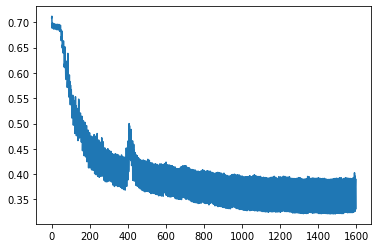

In [ ]:
plt.plot(losses)

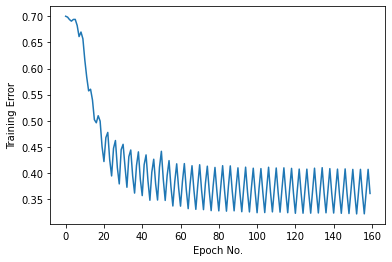

In [ ]:
losses_plt=[losses[i] for i in range(0,1600,10)]
epochs=range(0,160)
plt.xlabel('Epoch No.')
plt.ylabel('Training Error')
plt.plot(epochs,losses_plt)